<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#资源质量覆盖模型分析" data-toc-modified-id="资源质量覆盖模型分析-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>资源质量覆盖模型分析</a></span><ul class="toc-item"><li><span><a href="#数据读取" data-toc-modified-id="数据读取-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>数据读取</a></span><ul class="toc-item"><li><span><a href="#server_ip-=-'111.170.234.221'" data-toc-modified-id="server_ip-=-'111.170.234.221'-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>server_ip = '111.170.234.221'</a></span></li></ul></li><li><span><a href="#特征提取" data-toc-modified-id="特征提取-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>特征提取</a></span></li><li><span><a href="#准备mini-batches" data-toc-modified-id="准备mini-batches-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>准备mini-batches</a></span></li><li><span><a href="#建立模型" data-toc-modified-id="建立模型-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>建立模型</a></span><ul class="toc-item"><li><span><a href="#输入" data-toc-modified-id="输入-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>输入</a></span></li><li><span><a href="#LSTM-Cell" data-toc-modified-id="LSTM-Cell-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>LSTM Cell</a></span></li><li><span><a href="#RNN-输出" data-toc-modified-id="RNN-输出-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>RNN 输出</a></span></li><li><span><a href="#损失函数" data-toc-modified-id="损失函数-1.4.4"><span class="toc-item-num">1.4.4&nbsp;&nbsp;</span>损失函数</a></span></li><li><span><a href="#优化器" data-toc-modified-id="优化器-1.4.5"><span class="toc-item-num">1.4.5&nbsp;&nbsp;</span>优化器</a></span></li><li><span><a href="#建立网络" data-toc-modified-id="建立网络-1.4.6"><span class="toc-item-num">1.4.6&nbsp;&nbsp;</span>建立网络</a></span></li></ul></li><li><span><a href="#超参数" data-toc-modified-id="超参数-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>超参数</a></span></li><li><span><a href="#Time-for-training" data-toc-modified-id="Time-for-training-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Time for training</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Saved-checkpoints" data-toc-modified-id="Saved-checkpoints-1.6.0.1"><span class="toc-item-num">1.6.0.1&nbsp;&nbsp;</span>Saved checkpoints</a></span></li></ul></li></ul></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Prediction</a></span></li></ul></li></ul></div>

In [1]:
import os
import sklearn
from sklearn import preprocessing

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import time
from datetime import datetime, timedelta
from tzlocal import get_localzone # $ pip install tzlocal
import math
import seaborn as sns
%matplotlib inline

In [2]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


# 资源质量覆盖模型分析
    目前达标率是基于Haproxy日志进行分析，主要分析的业务有直播转点播业务、下载、点播业务。其他产品线由于打印日志存在差异暂时无法接入POA.

## 数据读取

### server_ip = '111.170.234.221'
dir_path = "data/" + server_ip + "/"
files = os.listdir(dir_path)
df_arr = []
for f in files:
    if(f.find(".csv") != -1):
        day_df = pd.read_csv(dir_path + f )
        df_arr.append(day_df)
df = pd.concat(df_arr)

In [4]:
df['time'] = pd.to_datetime(df['time'],unit='s')
#timezone
df['time']=df['time']+timedelta(hours=8)

In [5]:
output_cols = ['value_a_count','value_b_count','value_c_count','all_count','reach_rate_a','reach_rate_b','reach_rate_c']
other_cols = ['time','day','server_ip']

df = df.sort_values('time')
df = df.drop("reach_rate")
df['reach_rate_a'] = df['value_a_count']/ df['all_count']
df['reach_rate_b'] = df['value_b_count']/ df['all_count']
df['reach_rate_c'] = df['value_c_count']/ df['all_count']  

## 特征提取

http://www.sthda.com/english/wiki/correlation-test-between-two-variables-in-r

In [6]:
def prepare_date(df, output_cols, other_cols):
    #add cols

    input_cols = []
    for col in df.columns.values:
        if (col not in output_cols):
            input_cols.append(col)
    for col in other_cols:
        input_cols.remove(col)

    input_df = df[input_cols]

    output_df = df[output_cols]

    other_df = df[other_cols]

    #scale inputs
    input_null_pos = input_df == -1
    input_df[input_null_pos] = np.nan
    input_df = input_df.fillna(method='pad')
    #  pad / ffill: propagate last valid observation forward to next valid
    input_df = input_df.fillna(method='backfill')
    # bfill: use NEXT valid observation to fill gap
    input_df = input_df.fillna(value=0)
    scaler = preprocessing.MinMaxScaler().fit(input_df)
    input_scaled = scaler.transform(input_df)

    input_scaled_df = pd.DataFrame(input_scaled)
    input_scaled_df.columns = input_df.columns
    input_scaled_df.index = input_df.index
    input_scaled_df[input_null_pos] = -1

    output_df = output_df.fillna(0)
    other_df = other_df.fillna(0)
    return input_scaled_df, output_df, other_df

In [7]:
input_df, output_df,other_df = prepare_date(df,output_cols,other_cols)

/home/vode/anaconda3/envs/tensorflow1.2.1/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/vode/anaconda3/envs/tensorflow1.2.1/lib/python3.5/site-packages/pandas/core/frame.py:2392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.where(-key, value, inplace=True)


计算特征之间的相关系数，如果相关系数绝对值接近1,那么两个特征近似线性相关，可以去除其中一个特征

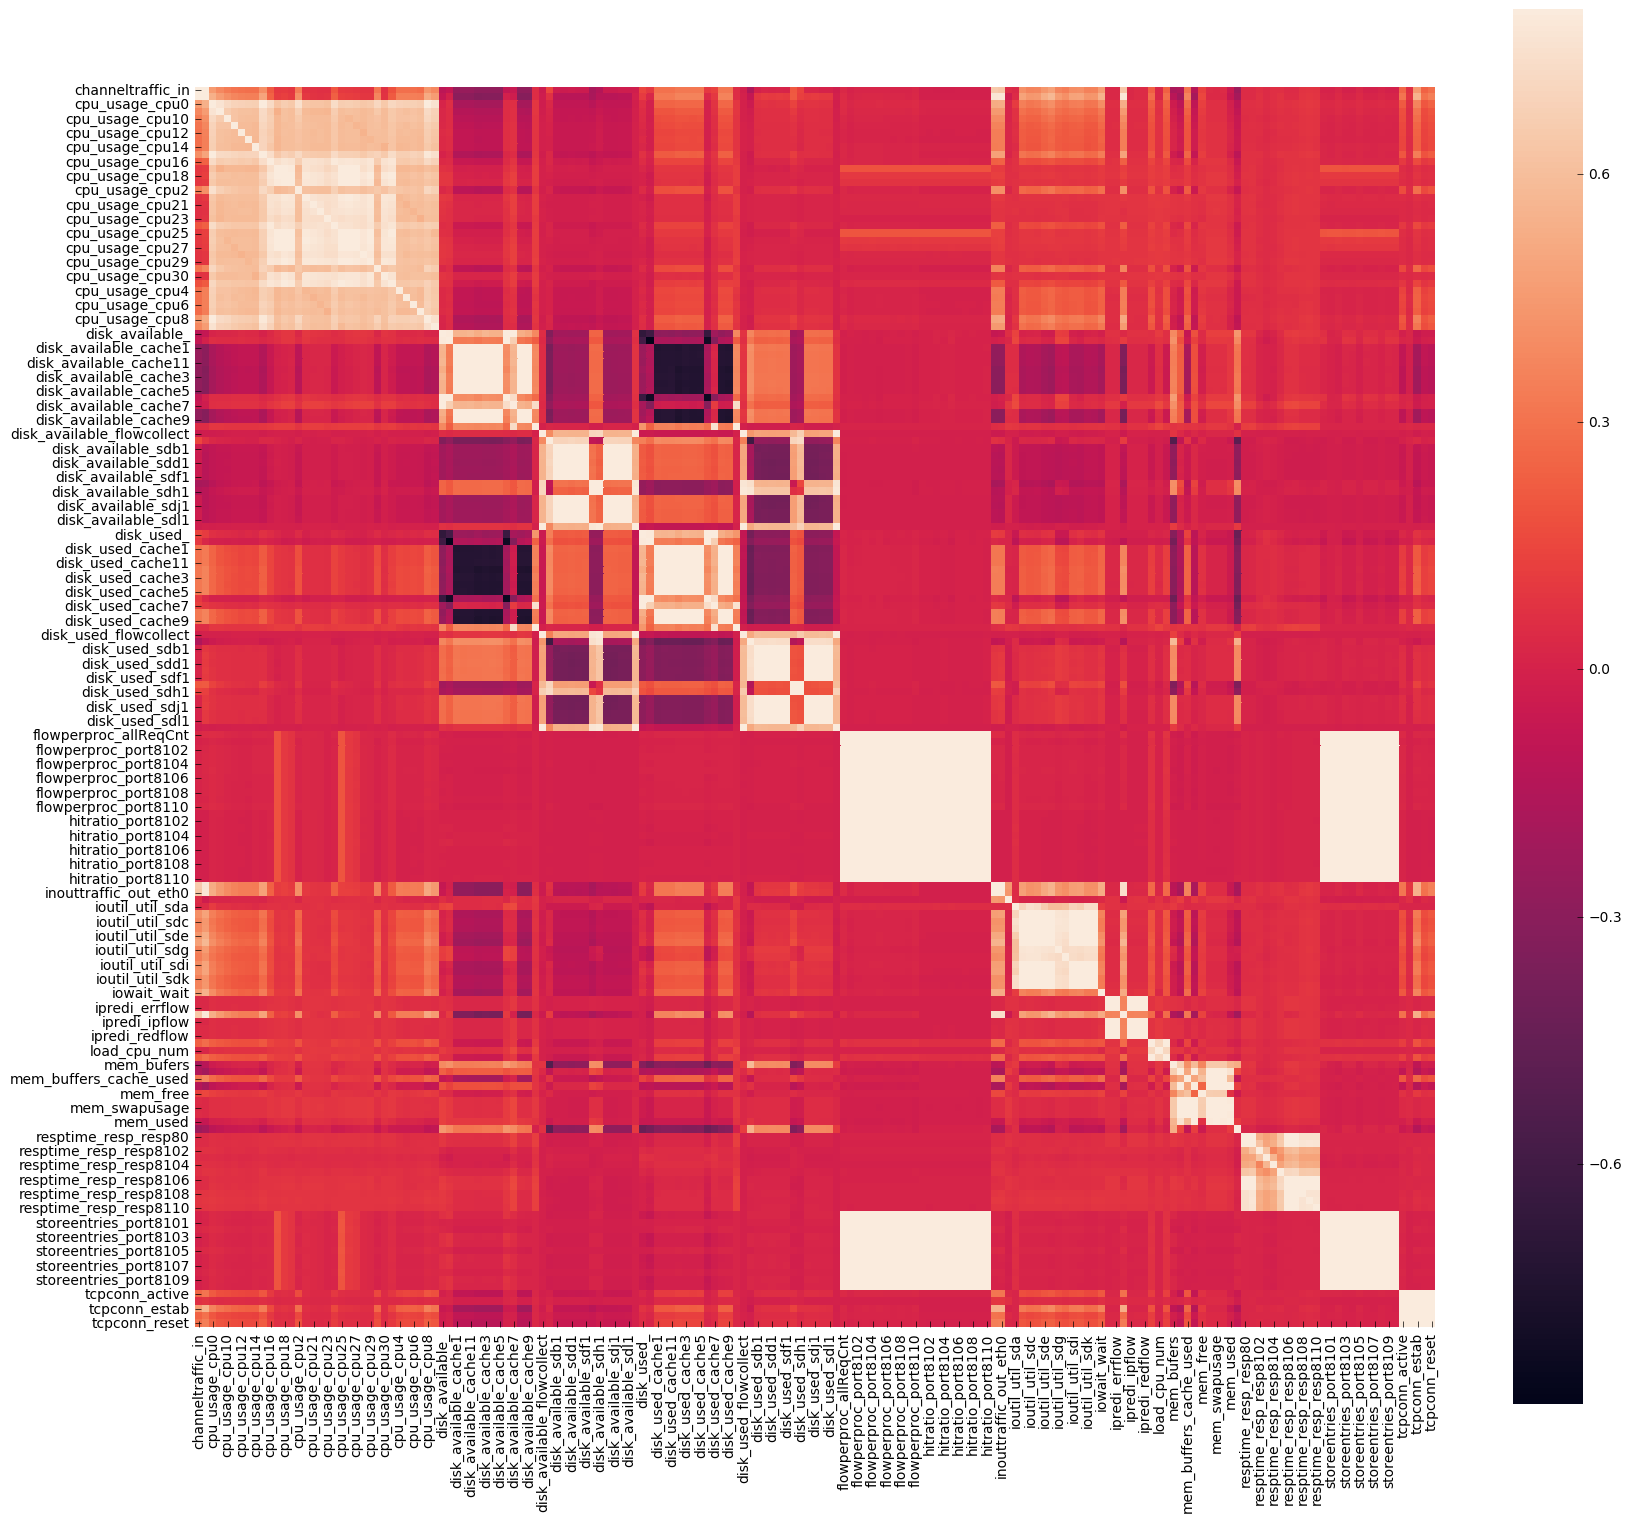

In [8]:
#correlation matrix
input_corrmat = input_df.corr()
f, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(input_corrmat, vmax=.8, square=True);

In [9]:
input_corrmat_abs=input_corrmat.abs()
input_corr_num=0

dic={i:0 for i in list(input_df.columns)}
for indexs in input_corrmat_abs.index:
    for column in input_corrmat_abs.columns: 
        if input_corrmat_abs.loc[indexs,column]>0.95:   #相关系数绝对值大于0.95
            input_corr_num+=1
            dic[indexs]+=1
            dic[column]+=1

In [10]:
for t in dic.keys():
    dic[t]=int(dic[t]/2)
sort_list=sorted(dic.items(), key=lambda x:x[1],reverse=True)  #len=173
sort_list                                                   #每个特征拥有的线性相关的特征数

[('storeentries_port8108', 32),
 ('storeentries_port8109', 32),
 ('storeentries_port8106', 32),
 ('hitratio_port8103', 32),
 ('flowperproc_port8105', 32),
 ('storeentries_port8104', 32),
 ('storeentries_port8101', 32),
 ('flowperproc_port8106', 32),
 ('storeentries_port8107', 32),
 ('hitratio_port8106', 32),
 ('hitratio_port8105', 32),
 ('flowperproc_port8110', 32),
 ('flowperproc_port8107', 32),
 ('storeentries_port8103', 32),
 ('hitratio_port8107', 32),
 ('hitratio_port8101', 32),
 ('flowperproc_port8103', 32),
 ('storeentries_port8105', 32),
 ('flowperproc_port8101', 32),
 ('hitratio_port8104', 32),
 ('hitratio_port8108', 32),
 ('storeentries_allStoreECnt', 32),
 ('flowperproc_port8109', 32),
 ('hitratio_port8110', 32),
 ('hitratio_port8102', 32),
 ('storeentries_port8110', 32),
 ('flowperproc_port8102', 32),
 ('hitratio_port8109', 32),
 ('storeentries_port8102', 32),
 ('flowperproc_port8108', 32),
 ('flowperproc_port8104', 32),
 ('flowperproc_allReqCnt', 32),
 ('disk_available_sdi1

In [11]:
indexs='flowperproc_allReqCnt' #32                        #有32个特征互相之间相关系数都大于0.95，去除其中的31个特征
flowperproc_allReqCnt_corr_list=[]
for column in input_corrmat_abs.columns: 
    if input_corrmat_abs.loc[indexs,column]>0.95:   #0.95-
        flowperproc_allReqCnt_corr_list.append(column)
flowperproc_allReqCnt_corr_list.remove('flowperproc_allReqCnt')

indexs='ipredi_allsumflow' #5
ipredi_allsumflow_corr_list=[]
for column in input_corrmat_abs.columns: 
    if input_corrmat_abs.loc[indexs,column]>0.95:   
        ipredi_allsumflow_corr_list.append(column)
ipredi_allsumflow_corr_list.remove('ipredi_allsumflow')


indexs='disk_used_cache1' #9
disk_used_cache1_corr_list=[]
for column in input_corrmat_abs.columns: 
    if input_corrmat_abs.loc[indexs,column]>0.95:   
        disk_used_cache1_corr_list.append(column)
disk_used_cache1_corr_list.remove('disk_used_cache1')


indexs='disk_available_cache1' #9
disk_available_cache1_corr_list=[]
for column in input_corrmat_abs.columns: 
    if input_corrmat_abs.loc[indexs,column]>0.95:   
        disk_available_cache1_corr_list.append(column)
disk_available_cache1_corr_list.remove('disk_available_cache1')


indexs='disk_used_sdb1' #9
disk_used_sdb1_corr_list=[]
for column in input_corrmat_abs.columns: 
    if input_corrmat_abs.loc[indexs,column]>0.95:   
        disk_used_sdb1_corr_list.append(column)
disk_used_sdb1_corr_list.remove('disk_used_sdb1')


indexs='disk_available_sdb1' #9           173-(32-1)-4*(9-1)-(5-1)=106
disk_available_sdb1_corr_list=[]
for column in input_corrmat_abs.columns: 
    if input_corrmat_abs.loc[indexs,column]>0.95:   
        disk_available_sdb1_corr_list.append(column)
disk_available_sdb1_corr_list.remove('disk_available_sdb1')

In [12]:
drop_features_list=flowperproc_allReqCnt_corr_list+ipredi_allsumflow_corr_list+disk_used_cache1_corr_list+disk_available_cache1_corr_list+disk_used_sdb1_corr_list+disk_available_sdb1_corr_list

In [13]:
#drop_features_list  要删除的特征列表 删除以后特征数为106
drop_input_df=input_df.drop(drop_features_list,axis=1)
drop_input_df.head()

,channeltraffic_in,channeltraffic_out,cpu_usage_cpu0,cpu_usage_cpu1,cpu_usage_cpu10,cpu_usage_cpu11,cpu_usage_cpu12,cpu_usage_cpu13,cpu_usage_cpu14,cpu_usage_cpu15,...,resptime_resp_resp8106,resptime_resp_resp8107,resptime_resp_resp8108,resptime_resp_resp8109,resptime_resp_resp8110,tcpconn_active,tcpconn_attemptfailed,tcpconn_estab,tcpconn_passive,tcpconn_reset
0,0.139401,0.158773,0.133213,0.086791,0.068603,0.049977,0.042655,0.046715,0.061403,0.057601,...,0.0,0.0,0.000000,0.0,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,0.183391,0.172142,0.105378,0.059509,0.098935,0.072150,0.072609,0.074447,0.058461,0.065988,...,0.0,0.0,0.083333,0.0,0.000000,0.094107,0.005721,0.173592,0.175357,0.121392
2,0.160939,0.159504,0.094536,0.097280,0.056339,0.338966,0.034464,0.040483,0.048605,0.075338,...,0.0,0.0,0.000000,0.0,0.000000,0.082884,0.009153,0.165233,0.149468,0.099196
3,0.190286,0.164674,0.098691,0.078225,0.047239,0.041631,0.041162,0.026709,0.058226,0.086476,...,0.0,0.0,0.000000,0.0,0.000000,0.088496,0.010297,0.170321,0.125620,0.085833
4,0.135287,0.169558,0.115277,0.069762,0.105355,0.053480,0.125961,0.069269,0.091226,0.060457,...,0.0,0.0,0.000000,0.0,0.083333,0.077833,0.012014,0.158571,0.122183,0.082070


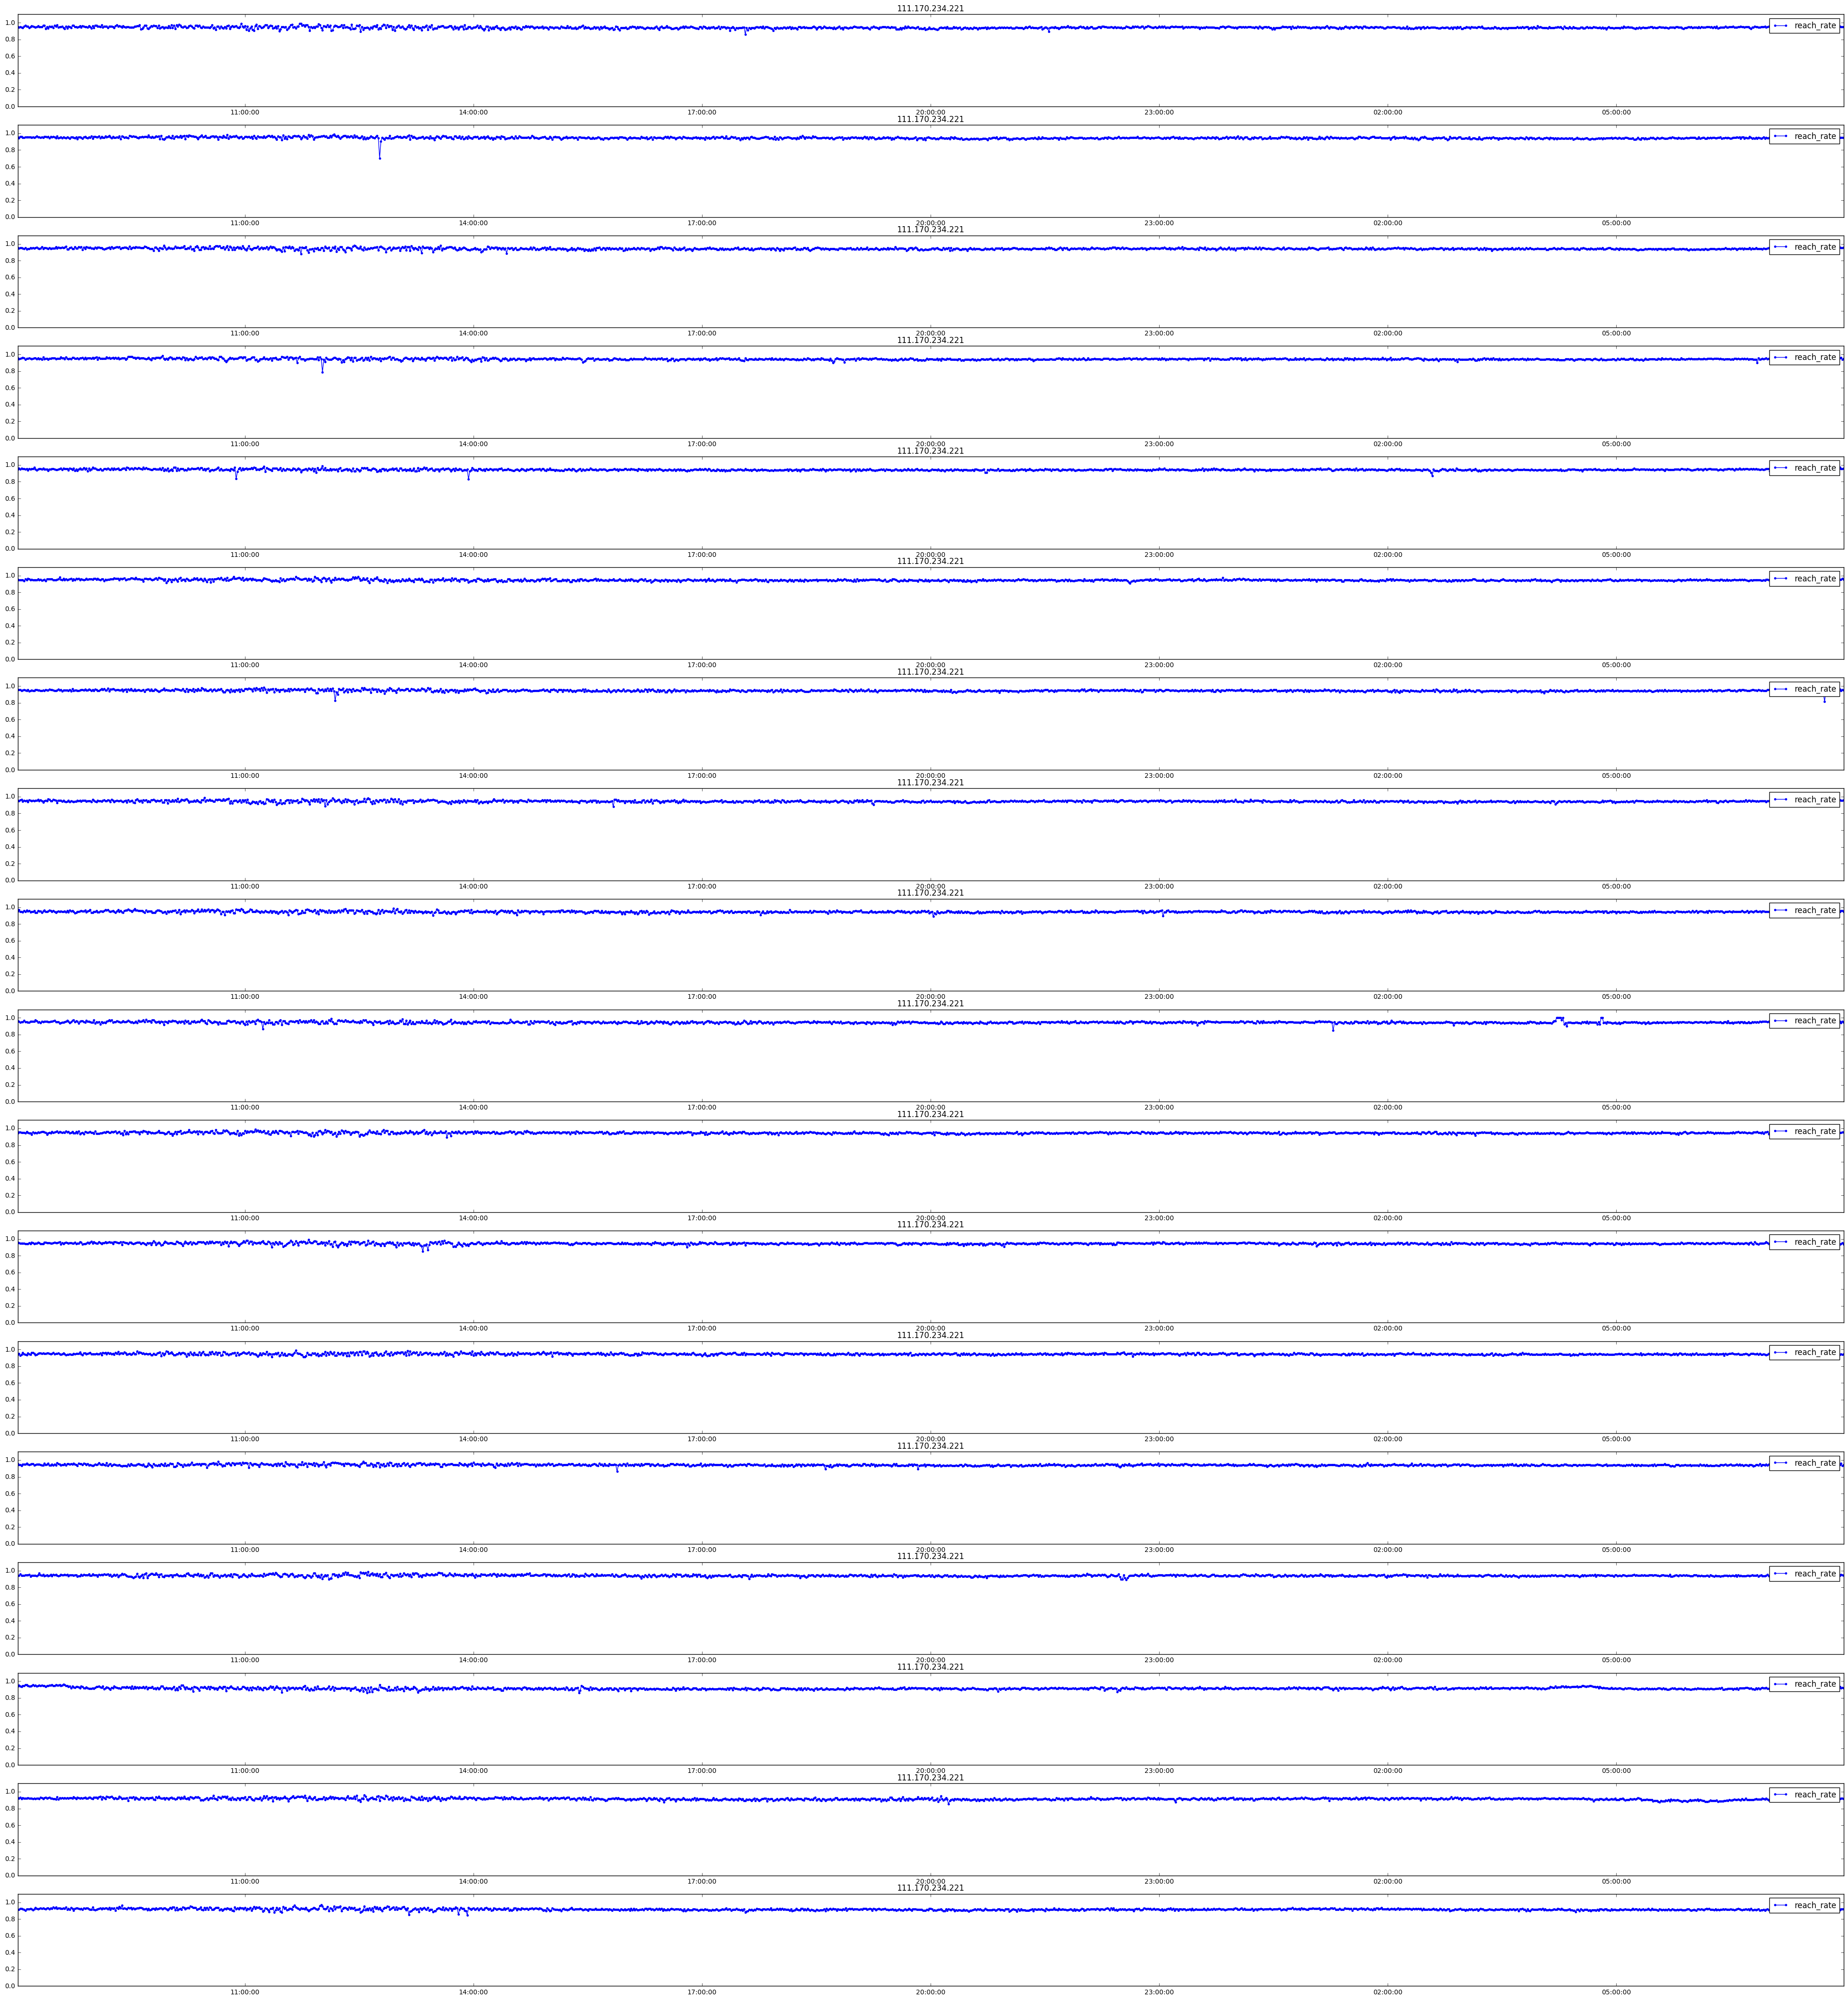

In [14]:
local_tz = get_localzone()
xfmt = mpl.dates.DateFormatter('%H:%M:%S',tz=local_tz)

st = np.min(df['time'])
et = np.max(df['time'])
difft = (et - st)
days = difft.days
offset = timedelta(1)

plt.figure(figsize=(50,3*days)) 
for i in range(days):
    range_st = st + i * offset
    range_et = range_st + offset
    range_df = df[np.logical_and(df['time'] > range_st, df['time'] < range_et) ]
    plt.subplot(days,1,i+1)
    plt.title(server_ip)
    plt.plot(range_df.time.values, range_df['reach_rate_a'].values, '.-',label="reach_rate")


    ax=plt.gca()
    ax.set_ylim([0,1.1])
    ax.xaxis.set_major_formatter(xfmt)

    plt.legend()
    
plt.legend()
plt.show()

In [45]:
num = df.shape[0]
train_num = int(num * 0.7)
train_num = math.ceil(train_num / (60*24)) * 60 * 24 # 取整数的天
test_num = num - train_num
#训练数据和测试数据
#train_df = df[:train_num]
#test_df = df[train_num:]

X = drop_input_df[:train_num]
Y = output_df[:train_num]['reach_rate_c']

test_X = drop_input_df[train_num:]
test_Y = output_df[train_num:]['reach_rate_c']

x=X.values
y=Y.values

In [46]:
#http://pandas.pydata.org/pandas-docs/stable/merging.html
arr=pd.concat([X,Y], axis=1, join_axes=[X.index]).values

In [47]:
arr.shape

(20160, 107)

## 准备mini-batches

In [48]:
num_steps=60
INPUT_SIZE=106     ###
TIME_STEP=60

In [49]:
x_formated_list = []
y_formated_list = []
for startIdx in range(TIME_STEP):
    endIdx = startIdx + (int((train_num -startIdx)  / TIME_STEP)*TIME_STEP)
    
    batch_x = x[startIdx:endIdx].reshape(-1,TIME_STEP,INPUT_SIZE)
    batch_y = y[startIdx + TIME_STEP-1: endIdx : TIME_STEP].reshape(-1,1)
    x_formated_list.append(batch_x)
    y_formated_list.append(batch_y)
    
x_list=np.concatenate(x_formated_list)
y_list=np.concatenate(y_formated_list)

In [50]:
def get_batches(x_list, y_list, batch_size=50):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_dimensions: number of features of X
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    for Idx in range(0, len(x_list) - batch_size + 1, batch_size):
        batch_x = x_list[Idx:Idx + batch_size]
        batch_y = y_list[Idx:Idx + batch_size]
        yield batch_x, batch_y

In [51]:
#batches = get_batches(x_list, y_list,batch_size)
#x, y = next(batches)

In [52]:
x.shape

(20160, 106)

## 建立模型




### 输入


In [53]:
def build_inputs(batch_size, num_steps, input_size, output_size):
    ''' Define placeholders for inputs, targets, and dropout 
    
        Arguments
        ---------
        batch_size: Batch size, number of sequences per batch
        num_steps: Number of sequence steps in a batch
        
    '''
    # Declare placeholders we'll feed into the graph
    inputs = tf.placeholder(
        tf.float32, [batch_size, num_steps, input_size], name='inputs')
    targets = tf.placeholder(
        tf.float32, [batch_size, 1], name='targets')

    # Keep probability placeholder for drop out layers
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    return inputs, targets, keep_prob

### LSTM Cell

Here we will create the LSTM cell we'll use in the hidden layer. We'll use this cell as a building block for the RNN. So we aren't actually defining the RNN here, just the type of cell we'll use in the hidden layer.

We first create a basic LSTM cell with

```python
lstm = tf.contrib.rnn.BasicLSTMCell(num_units)
```

where `num_units` is the number of units in the hidden layers in the cell. Then we can add dropout by wrapping it with 

```python
tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
```
You pass in a cell and it will automatically add dropout to the inputs or outputs. Finally, we can stack up the LSTM cells into layers with [`tf.contrib.rnn.MultiRNNCell`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/rnn/MultiRNNCell). With this, you pass in a list of cells and it will send the output of one cell into the next cell. For example,

```python
tf.contrib.rnn.MultiRNNCell([cell]*num_layers)
```

This might look a little weird if you know Python well because this will create a list of the same `cell` object. However, TensorFlow will create different weight matrices for all `cell` objects. Even though this is actually multiple LSTM cells stacked on each other, you can treat the multiple layers as one cell.

We also need to create an initial cell state of all zeros. This can be done like so

```python
initial_state = cell.zero_state(batch_size, tf.float32)
```

In [54]:
def build_lstm(lstm_size, num_layers, batch_size, keep_prob):
    ''' Build LSTM cell.
    
        Arguments
        ---------
        keep_prob: Scalar tensor (tf.placeholder) for the dropout keep probability
        lstm_size: Size of the hidden layers in the LSTM cells
        num_layers: Number of LSTM layers
        batch_size: Batch size

    '''
    ### Build the LSTM Cell
    # Use a basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    
    # Add dropout to the cell
    #drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    #Stack up multiple LSTM layers, for deep learning
    #cell = tf.contrib.rnn.MultiRNNCell([drop] * num_layers)
    cell = tf.contrib.rnn.MultiRNNCell([lstm] * num_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, initial_state

### RNN 输出

In [55]:
def build_output(lstm_output, in_size, output_size):
    ''' Build a softmax layer, return the softmax output and logits.
    
        Arguments
        ---------
        
        lstm_output: List of output tensors from the LSTM layer
        in_size: Size of the input tensor, for example, size of the LSTM cells
        out_size: Size of this softmax layer
    
    '''
    # 全连接层
    seq_output = tf.concat(lstm_output, axis=1)
    x = tf.reshape(seq_output, [-1, in_size])
    
    # Connect the RNN outputs to a softmax layer
    with tf.variable_scope('fully_conected'):
        fully_conected_w = tf.Variable(tf.truncated_normal((in_size, output_size), stddev=0.1))
        fully_conected_b = tf.Variable(tf.zeros(output_size))

    out = tf.matmul(x, fully_conected_w) + fully_conected_b
    
    return out

### 损失函数

In [56]:
def build_loss(logits, targets):
    ''' Calculate the loss from the logits and the targets.
    
        Arguments
        ---------
    '''
    #y_reshaped = tf.reshape(targets, (batch_size,1))
    loss = tf.losses.mean_squared_error (predictions=logits, labels=targets)
    return loss

### 优化器

In [57]:
def build_optimizer(loss, learning_rate, grad_clip):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
    return optimizer

### 建立网络

In [58]:
class TS_RNN:
    def __init__(self,
                 batch_size=64,
                 num_steps=60,
                 lstm_size=128,
                 num_layers=2,
                 learning_rate=0.001,
                 grad_clip=5,
                 sampling=False,
                 input_size=106,
                 output_size=1):

        # When we're using this network for sampling later, we'll be passing in
        # one character at a time, so providing an option for that
        tf.reset_default_graph()

        # Build the input placeholder tensors
        self.inputs, self.targets, self.keep_prob = build_inputs(
            batch_size, num_steps, input_size, output_size)

        # Build the LSTM cell
        cell, self.initial_state = build_lstm(lstm_size, num_layers,
                                              batch_size, self.keep_prob)

        # Run each sequence step through the RNN and collect the outputs
        outputs, state = tf.nn.dynamic_rnn(
            cell, inputs=self.inputs, initial_state=self.initial_state)
        self.final_state = state

        # Get softmax predictions and logits
        self.prediction = build_output(outputs[:,-1], lstm_size, output_size)

        # Loss and optimizer (with gradient clipping)
        self.loss = build_loss(self.prediction, self.targets)
        self.optimizer = build_optimizer(self.loss, learning_rate, grad_clip)

## 超参数

Here are the hyperparameters for the network.

* `batch_size` - Number of sequences running through the network in one pass.
* `num_steps` - Number of characters in the sequence the network is trained on. Larger is better typically, the network will learn more long range dependencies. But it takes longer to train. 100 is typically a good number here.
* `lstm_size` - The number of units in the hidden layers.
* `num_layers` - Number of hidden LSTM layers to use
* `learning_rate` - Learning rate for training
* `keep_prob` - The dropout keep probability when training. If you're network is overfitting, try decreasing this.

In [59]:
batch_size = 50         # Sequences per batch
num_steps = 60          # Number of sequence steps per batch
lstm_size = 20         # Size of hidden layers in LSTMs
num_layers = 1          # Number of LSTM layers
learning_rate = 0.01    # Learning rate
keep_prob = 1         # Dropout keep probability

## Time for training

This is typical training code, passing inputs and targets into the network, then running the optimizer. Here we also get back the final LSTM state for the mini-batch. Then, we pass that state back into the network so the next batch can continue the state from the previous batch. And every so often (set by `save_every_n`) I save a checkpoint.

Here I'm saving checkpoints with the format

`i{iteration number}_l{# hidden layer units}.ckpt`

> **Exercise:** Set the hyperparameters above to train the network. Watch the training loss, it should be consistently dropping. Also, I highly advise running this on a GPU.

In [60]:
epochs = 20
# Save every N iterations
save_every_n = 200

model = TS_RNN(batch_size=batch_size, num_steps=num_steps,
                lstm_size=lstm_size, num_layers=num_layers, 
                learning_rate=learning_rate)

saver = tf.train.Saver(max_to_keep=100)

In [61]:
trainLoss=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Use the line below to load a checkpoint and resume training
    #saver.restore(sess, 'checkpoints/______.ckpt')
    counter = 0
    for e in range(epochs):
        # Train network
        new_state = sess.run(model.initial_state)
        loss = 0
        for x, y in get_batches(x_list, y_list, batch_size=batch_size):
            counter += 1         #遍历一次的输入次数
            start = time.time()
            feed = {model.inputs: x,
                    model.targets: y,
                    model.keep_prob: keep_prob,
                    model.initial_state: new_state}
            batch_loss, new_state, _ = sess.run([model.loss, 
                                                 model.final_state, 
                                                 model.optimizer], 
                                                 feed_dict=feed)
            
            end = time.time()
            print('Epoch: {}/{}... '.format(e+1, epochs),
                  'Training Step: {}... '.format(counter),
                  'Training loss: {:.4f}... '.format(batch_loss),
                  '{:.4f} sec/batch'.format((end-start)))
            trainLoss.append(batch_loss)
        
            if (counter % save_every_n == 0):
                saver.save(sess, "checkpoints/i{}_l{}.ckpt".format(counter, lstm_size))
    
    saver.save(sess, "checkpoints/i{}_l{}.ckpt".format(counter, lstm_size))

Epoch: 1/20...  Training Step: 1...  Training loss: 0.6261...  0.0367 sec/batch
Epoch: 1/20...  Training Step: 2...  Training loss: 0.1881...  0.0228 sec/batch
Epoch: 1/20...  Training Step: 3...  Training loss: 0.0271...  0.0225 sec/batch
Epoch: 1/20...  Training Step: 4...  Training loss: 0.0033...  0.0207 sec/batch
Epoch: 1/20...  Training Step: 5...  Training loss: 0.0332...  0.0217 sec/batch
Epoch: 1/20...  Training Step: 6...  Training loss: 0.0474...  0.0239 sec/batch
Epoch: 1/20...  Training Step: 7...  Training loss: 0.0407...  0.0259 sec/batch
Epoch: 1/20...  Training Step: 8...  Training loss: 0.0217...  0.0263 sec/batch
Epoch: 1/20...  Training Step: 9...  Training loss: 0.0070...  0.0268 sec/batch
Epoch: 1/20...  Training Step: 10...  Training loss: 0.0012...  0.0267 sec/batch
Epoch: 1/20...  Training Step: 11...  Training loss: 0.0065...  0.0207 sec/batch
Epoch: 1/20...  Training Step: 12...  Training loss: 0.0146...  0.0206 sec/batch
Epoch: 1/20...  Training Step: 13... 

/home/vode/anaconda3/envs/tensorflow1.2.1/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


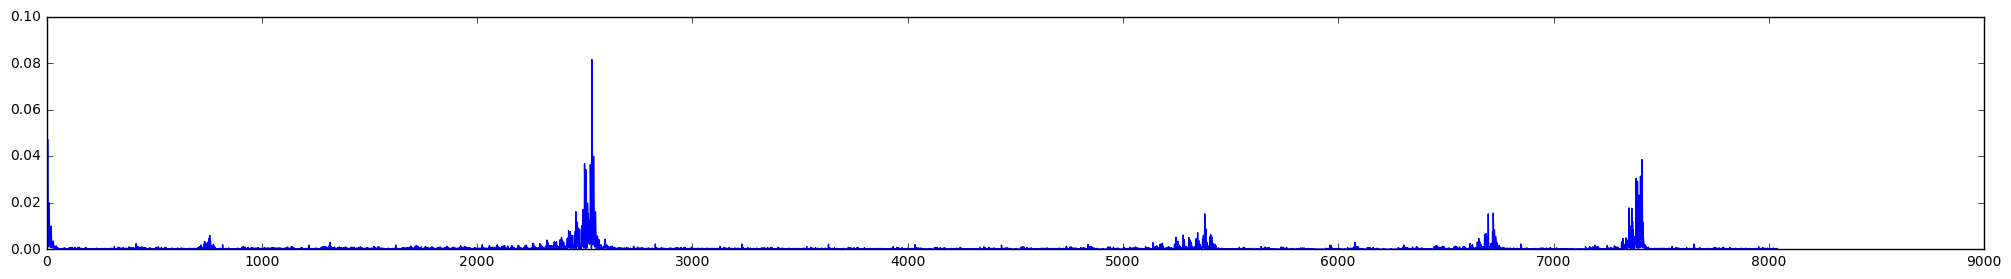

In [63]:
plt.figure(figsize=(25,3))
plt.plot(trainLoss)
ax=plt.gca()
ax.set_ylim([0,0.1])
plt.legend()
plt.show()

#### Saved checkpoints

Read up on saving and loading checkpoints here: https://www.tensorflow.org/programmers_guide/variables

In [ ]:
tf.train.get_checkpoint_state('checkpoints')

## Prediction

In [64]:
train_df = df[:train_num]
test_df = df[train_num:]

In [65]:
train_df.head()

,all_count,channeltraffic_in,channeltraffic_out,cpu_usage_cpu0,cpu_usage_cpu1,cpu_usage_cpu10,cpu_usage_cpu11,cpu_usage_cpu12,cpu_usage_cpu13,cpu_usage_cpu14,...,tcpconn_estab,tcpconn_passive,tcpconn_reset,time,value_a_count,value_b_count,value_c_count,reach_rate_a,reach_rate_b,reach_rate_c
0,801.0,303883488.0,3.050874e+09,17.169,11.195,9.322,7.236,6.387,6.845,8.101,...,-1.0,-1.00,-1.00,2017-09-06 00:00:00,776.0,745.0,715.0,0.968789,0.930087,0.892634
1,803.0,397184320.0,3.293496e+09,14.509,8.542,12.275,9.401,9.316,9.555,7.813,...,1821.0,224.25,226.05,2017-09-06 00:01:00,765.0,743.0,705.0,0.952677,0.925280,0.877958
2,722.0,349564512.0,3.064132e+09,13.473,12.215,8.128,35.454,5.586,6.236,6.848,...,1752.0,212.20,216.20,2017-09-06 00:02:00,681.0,660.0,632.0,0.943213,0.914127,0.875346
3,752.0,411808480.0,3.157964e+09,13.870,10.362,7.242,6.421,6.241,4.890,7.790,...,1794.0,201.10,210.27,2017-09-06 00:03:00,716.0,691.0,656.0,0.952128,0.918883,0.872340
4,694.0,295156352.0,3.246609e+09,15.455,9.539,12.900,7.578,14.533,9.049,11.021,...,1697.0,199.50,208.60,2017-09-06 00:04:00,657.0,628.0,601.0,0.946686,0.904899,0.865994


In [66]:
train_predict_df = pd.DataFrame(train_df['time'])
train_predict_df['res'] = np.nan
train_predict_df.head()

,time,res
0,2017-09-06 00:00:00,NaN
1,2017-09-06 00:01:00,NaN
2,2017-09-06 00:02:00,NaN
3,2017-09-06 00:03:00,NaN
4,2017-09-06 00:04:00,NaN


In [113]:
predict_df = pd.DataFrame(df['time'])
predict_df['res'] = np.nan
#predict_df.head()
#predict_df.iloc[0,1]

nan

In [68]:
input_list = []
num = df.shape[0]
drop_x=drop_input_df.values
predict_x_formated_list=[]
#startIdx=0
#endIdx = startIdx + (int((num -startIdx)  / TIME_STEP)*TIME_STEP)
#predict_batch_x = drop_x[startIdx:endIdx].reshape(-1,TIME_STEP,INPUT_SIZE)
#x_formated_list.append(predict_batch_x)



for startIdx in range(num-num_steps+1):
    predict_batch_x =drop_x[startIdx:startIdx+num_steps].reshape(1,num_steps,INPUT_SIZE)
    predict_x_formated_list.append(predict_batch_x)


In [71]:
predict_x_formated_list[0].shape[0],predict_x_formated_list[0].shape[1],predict_x_formated_list[0].shape[2]

(1, 60, 106)

In [76]:
predict_length=len(predict_x_formated_list)

In [114]:
def predict(checkpoint):
    model = TS_RNN(batch_size=1, num_steps=num_steps,
                lstm_size=lstm_size, num_layers=num_layers, 
                learning_rate=learning_rate)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, checkpoint)
        new_state = sess.run(model.initial_state)
        #for x, y in get_batches(x_list, y_list, batch_size=batch_size):
        for i in range(predict_length):
            feed = {model.inputs: predict_x_formated_list[i],
                    #model.targets: y,
                    #model.keep_prob: keep_prob,
                    model.initial_state: new_state}
            predict_values, new_state = sess.run([model.prediction, 
                                                 model.final_state], 
                                                 feed_dict=feed)
            predict_df.iloc[i+num_steps-2,1]=predict_values[0][0]

In [116]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
predict(checkpoint)

INFO:tensorflow:Restoring parameters from checkpoints/i8040_l20.ckpt


In [117]:
 predict_df

,time,res
0,2017-09-06 00:00:00,NaN
1,2017-09-06 00:01:00,NaN
2,2017-09-06 00:02:00,NaN
3,2017-09-06 00:03:00,NaN
4,2017-09-06 00:04:00,NaN
5,2017-09-06 00:05:00,NaN
6,2017-09-06 00:06:00,NaN
7,2017-09-06 00:07:00,NaN
8,2017-09-06 00:08:00,NaN
9,2017-09-06 00:09:00,NaN


In [128]:
train_predict_df= predict_df.iloc[0:train_num,:]
test_predict_df= predict_df.iloc[train_num:,:]
test_predict_df

,time,res
0,2017-09-20 00:00:00,0.859079
1,2017-09-20 00:01:00,0.861719
2,2017-09-20 00:02:00,0.862558
3,2017-09-20 00:03:00,0.854221
4,2017-09-20 00:04:00,0.841103
5,2017-09-20 00:05:00,0.799341
6,2017-09-20 00:06:00,0.867845
7,2017-09-20 00:07:00,0.784794
8,2017-09-20 00:08:00,0.867697
9,2017-09-20 00:09:00,0.858388


FileNotFoundError: [Errno 2] No such file or directory: '../img/lstm/server111.170.234.221_LR0.01_EPOCH20_TIME_STEP60_N_LAYER1_N_HIDDEN20.png'

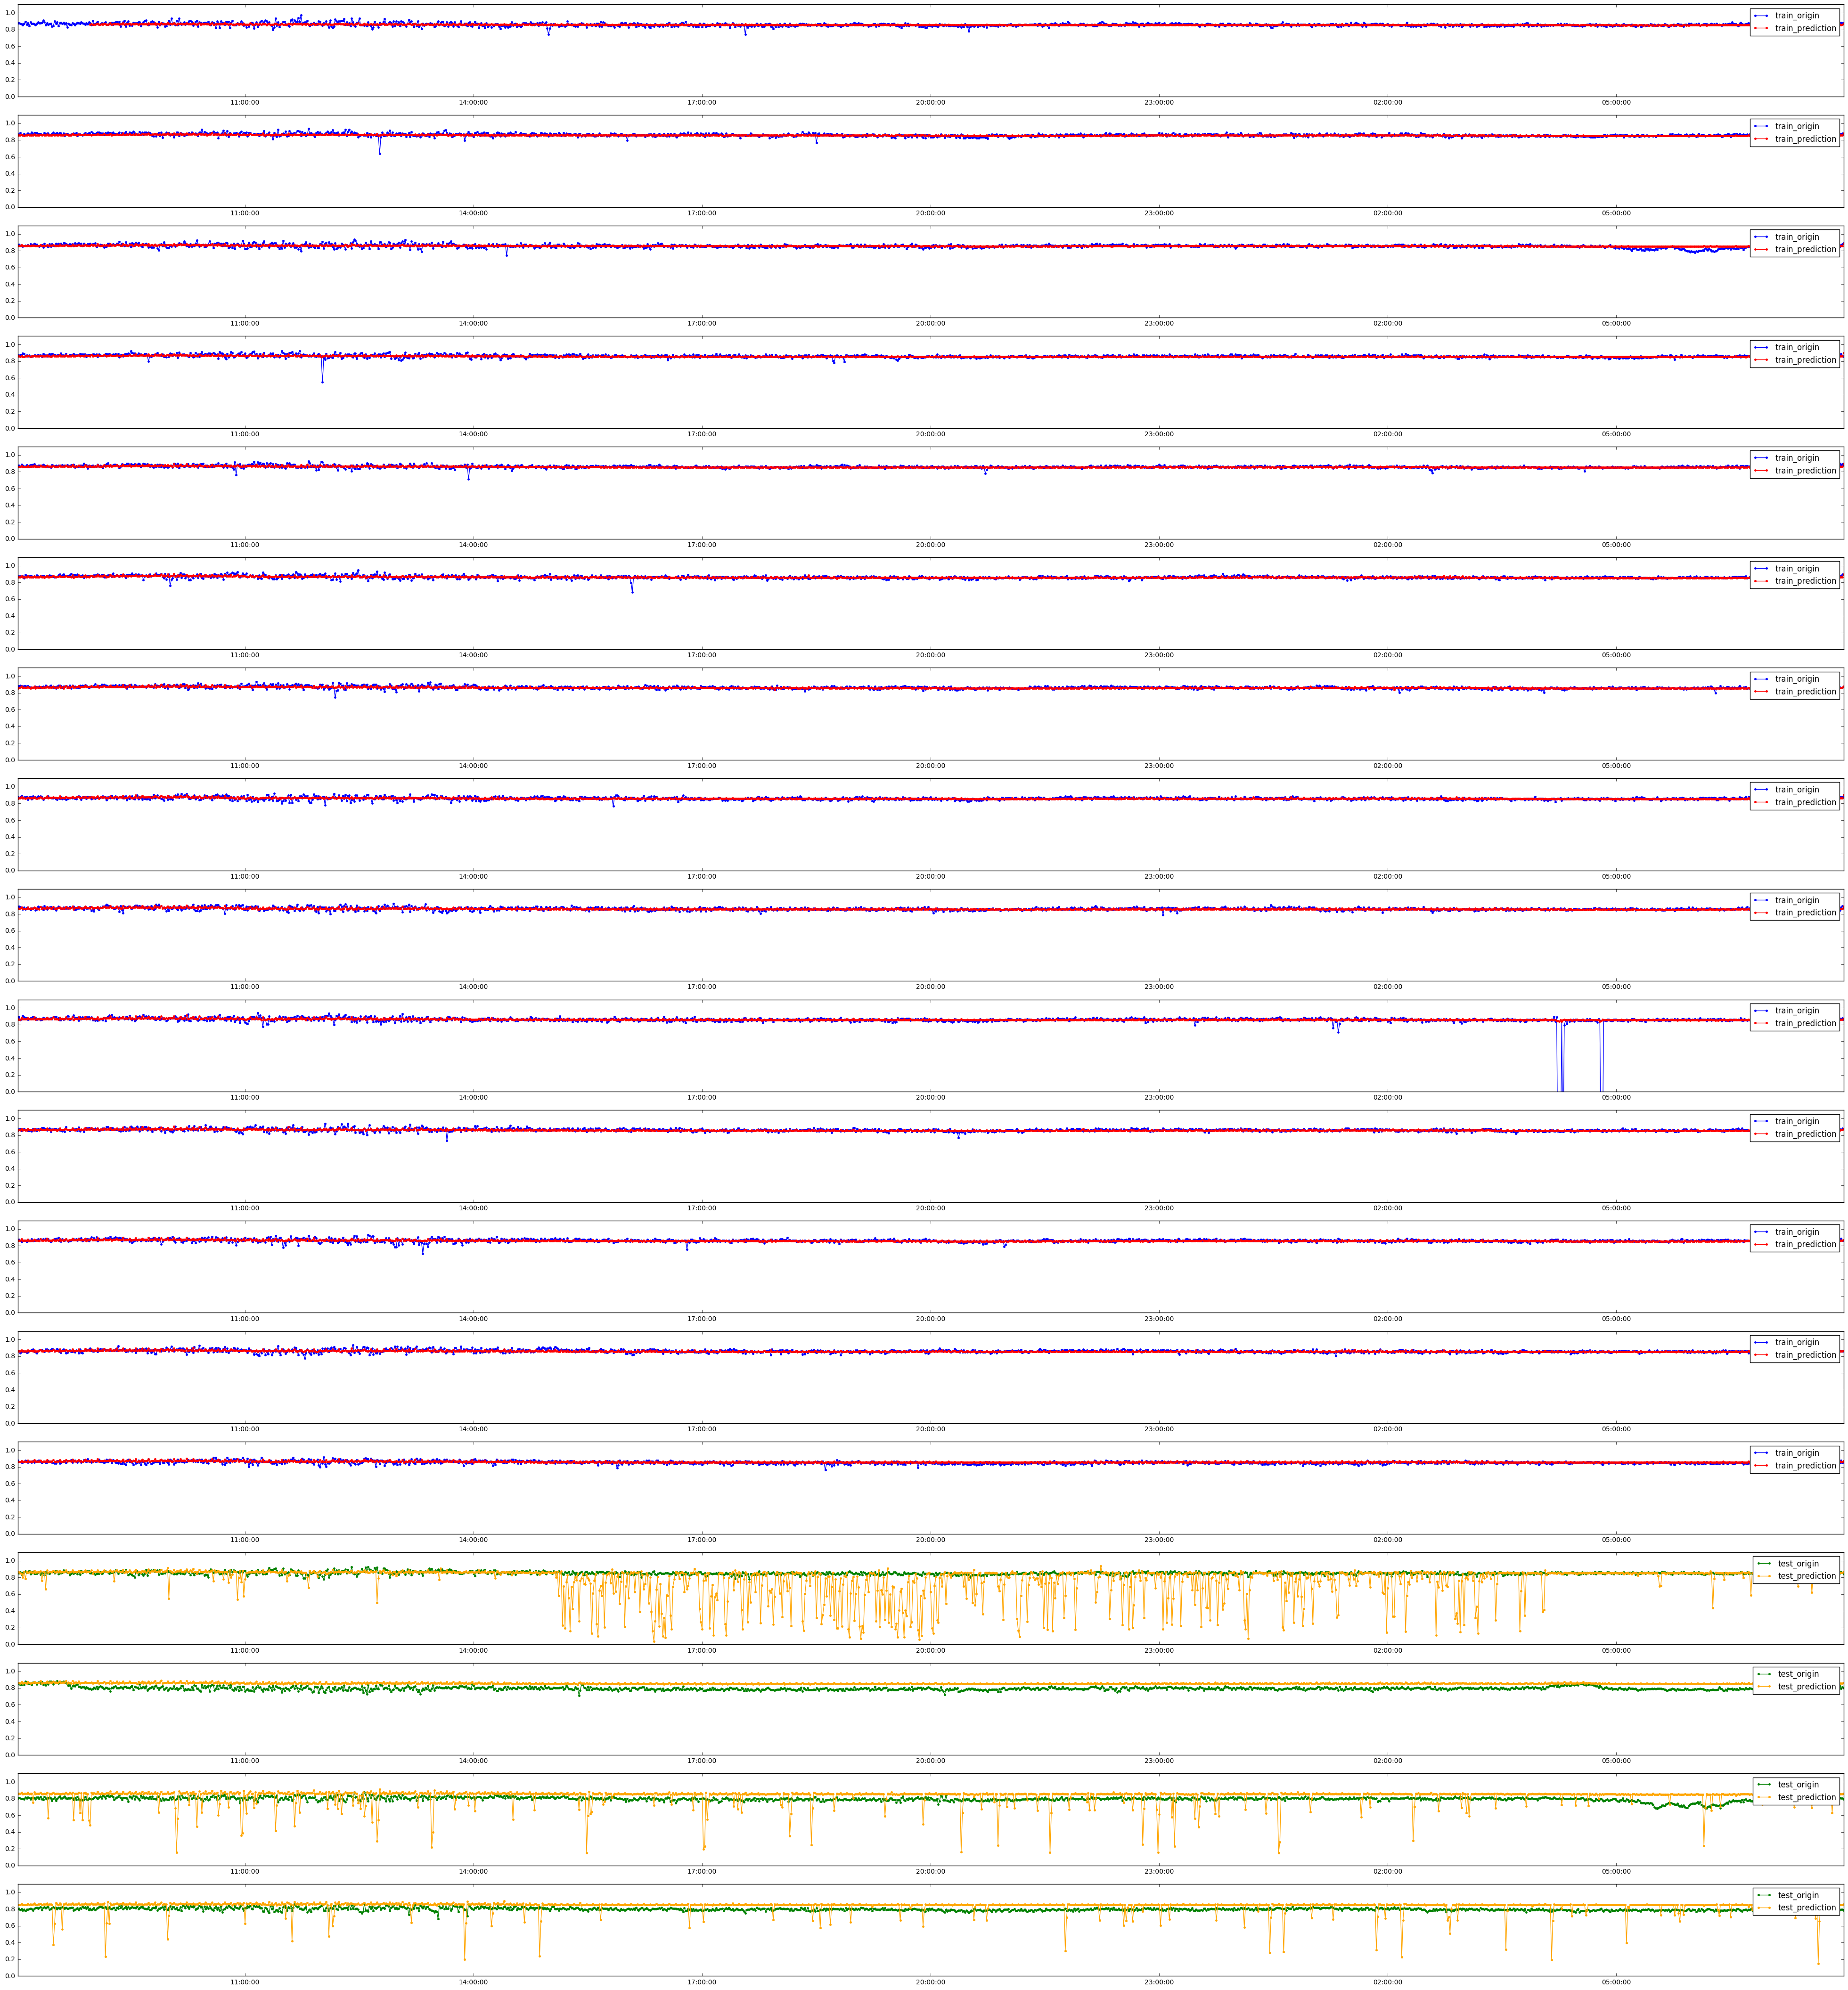

In [130]:
local_tz = get_localzone()
xfmt = mpl.dates.DateFormatter('%H:%M:%S',tz=local_tz)

st = np.min(df['time'])
et = np.max(df['time'])
difft = (et - st)
days = difft.days

train_st = np.min(train_df['time'])
train_et = np.max(train_df['time'])
train_days = int(train_num / (24*60))

test_st = np.min(test_df['time'])

offset = timedelta(1)

plt.figure(figsize=(50,3*days)) 
for i in range(train_days):
    range_st = st + i * offset
    range_et = range_st + offset
    range_df = train_df[np.logical_and(train_df['time'] > range_st, train_df['time'] < range_et) ]
    range_predict_df = train_predict_df[np.logical_and(train_predict_df['time'] > range_st, train_predict_df['time'] < range_et) ]
    plt.subplot(days,1,i+1)
    plt.plot(range_df.time.values, range_df.reach_rate.values, '.-',label="train_origin", color="blue")
    plt.plot(range_predict_df.time.values, range_predict_df.res.values, '.-',label="train_prediction",color="red")


    ax=plt.gca()
    ax.set_ylim([0,1.1])
    ax.xaxis.set_major_formatter(xfmt)
    plt.legend()
    
for i in range(days - train_days):
    range_st = test_st + i * offset
    range_et = range_st + offset
    range_df = test_df[np.logical_and(test_df['time'] > range_st, test_df['time'] < range_et) ]
    range_predict_df = test_predict_df[np.logical_and(test_predict_df['time'] > range_st, test_predict_df['time'] < range_et) ]
    plt.subplot(days,1,train_days + i+1)
    plt.plot(range_df.time.values, range_df.reach_rate.values, '.-',label="test_origin", color='green')
    plt.plot(range_predict_df.time.values, range_predict_df.res.values, '.-',label="test_prediction", color="orange")


    ax=plt.gca()
    ax.set_ylim([0,1.1])
    ax.xaxis.set_major_formatter(xfmt)
    plt.legend()    
plt.legend()
plt.savefig("../img/lstm/" + "server"+ server_ip + "_LR" +str(learning_rate) + "_EPOCH" +str(epochs) +"_TIME_STEP" + str(num_steps)+ "_N_LAYER"+ str(num_layers) + "_N_HIDDEN"+ str(lstm_size)+ ".png")
plt.show()

In [1]:
evaluable_cache_group_list=[              63307,               83346,               53933,
                         105713,               82895,              102742,
                         110040,               79743,              105702,
                          86794,              103721, 1172509055262240814,
                         105730, 1172515855242725417,              108848,
                          86259, 1172508071862267293,              105628,
                          11292, 1168008088666573720, 1172511687907009984,
                         109771,   19600969245461398,               83077,
                          73843,              104780,               20814,
                         105710,               82897,               88170,
                          94161,              104798,              109940,
                          87569,               99529,               77484,
                          53917,              108850, 1163503507880657011,
                          86856,               83326,               72010,
                         103722,               53914,               92317,
                          90109,               77680,              105701]

In [2]:
len(evaluable_cache_group_list)

48

In [3]:
evaluable_cache_group_list.reverse()

In [4]:
for group in evaluable_cache_group_list:
    gro

[105701,
 77680,
 90109,
 92317,
 53914,
 103722,
 72010,
 83326,
 86856,
 1163503507880657011,
 108850,
 53917,
 77484,
 99529,
 87569,
 109940,
 104798,
 94161,
 88170,
 82897,
 105710,
 20814,
 104780,
 73843,
 83077,
 19600969245461398,
 109771,
 1172511687907009984,
 1168008088666573720,
 11292,
 105628,
 1172508071862267293,
 86259,
 108848,
 1172515855242725417,
 105730,
 1172509055262240814,
 103721,
 86794,
 105702,
 79743,
 110040,
 102742,
 82895,
 105713,
 53933,
 83346,
 63307]